# Exercise 11: NUDGED ELASTIC BAND and FREE ENERGY CALCULATIONS

Molecular and Materials Modelling: ETH Zürich, FS 2023

Date: Wednesday, 24. May 2023

Due Date: ---

Raymond Amador, Daniele Passerone, Carlo Pignedoli

ramador@ethz.ch

## 0. Introduction to the problem

In this exercise we will study the $S_N2$ nucleophilic substitution reaction

\begin{equation}
\text{Cl}^- + \text{CH}_3\text{Cl} \leftrightarrow \text{ClCH}_3 + \text{Cl}^-
\end{equation}

The notation $S_N2$ is lingo in the community of organic chemists, whereby the $S$ indicates *substitution*, the $N$ stands for *nucleophilic*, and the 2 means that this is a **bi**molecular reaction: i.e., the overall rate of reaction depends on a step in which two species collide.  For energy and force evaluation, we will use the Parameterization Method 6 (PM6), which is a relatively inexpensive semiempirical model for electronic structure evaluation. Semiempirical methods are based on mean-field theories such as Hartree-Fock and DFT, but the integrals are parametrized: parameters are obtained from empirical data, which is useful in systems whereby a full SCF in Hartree-Fock or DFT would otherwise be too expensive. For a more accurate characterization of the reaction, ab initio methods such as DFT or higher level, should be used in place of semiempirical methods.

<div>
<img src="chloromethane.png" width="500"/>
</div>

Fig. 1: a ball-and-stick model of chloromethane, with chemical formula $\text{CH}_3\text{Cl}$. This exercise seeks to study the substitution reaction in Eq. 1.

### 1.1. NEB activation barrier

In order to find the activation barrier for the reaction we will use the **nudged elastic band** (NEB) method. The NEB method provides a way to find the **minimum energy path** (MEP) between two different conformations of the system corresponding local potential energy minima. The MEP is a one-dimensional path on the $3N$-dimensional potential energy landscape and every point on the MEP is a potential energy minimum in all directions perpendicular to the path. MEP passes at least one saddle point and the energy of the highest saddle point is the peak of the activation barrier of the reaction.

<div>
<img src="ES.jpg" width="500"/>
</div>

Fig. 2: A pictorial representation of the basic idea behind an NEB activation barrier. The yellow and red ball represent the two minima; white balls represent intermediate states, while the black ball represents the transition state. Courtesy of Carlo Pignedoli, Empa.

## 2. Geometry optimizations

We begin by logging into our accounts on JupyterHub on Euler in a similar manner as described in the previous exercises, and `pull` the newest exercise files from the GitHub repository, making sure that you are in the directory for the course:
```bash
    $ cd ~/Molecular-and-Materials-Modelling-FS2023
    $ git init
  # $ git stash
    $ git pull https://github.com/ramador09/Molecular-and-Materials-Modelling-FS2023.git
```

To start the NEB calculation, we first need two different geometries at local energy minima, which we can obtain by running geometry optimization calculations. Open the `geo-opt-a.inp` input file using `vim`:

```
&GLOBAL
  PRINT_LEVEL LOW
  PROJECT ch3cl
  RUN_TYPE GEO_OPT        # Geometry optimization calculation
&END GLOBAL

&MOTION
  &GEO_OPT                # Parameters for GEO_OPT convergence
    MAX_FORCE 1.0E-4
    MAX_ITER 2000
    OPTIMIZER BFGS
    &BFGS
      TRUST_RADIUS [bohr] 0.1
    &END
  &END GEO_OPT
&END MOTION

&FORCE_EVAL
  METHOD Quickstep        # Quickstep - Electronic structure methods
  &DFT
   CHARGE -1              # There is a negatively charged anion
    &QS
      METHOD PM6          # Parametrization Method 6
      &SE
      &END SE
    &END QS
    &SCF                  # Convergence parameters for force evaluation
      SCF_GUESS ATOMIC
      EPS_SCF 1.0E-5
      MAX_SCF 50
       &OUTER_SCF
          EPS_SCF 1.0E-7
          MAX_SCF 500
       &END
    &END SCF
    &POISSON              # POISSON solver for non-periodic calculation
      PERIODIC NONE
      PSOLVER WAVELET
    &END
  &END DFT

  &SUBSYS
    &CELL
      ABC 10.0 10.0 10.0
      PERIODIC NONE
    &END CELL
    &COORD
C      -4.03963494       0.97427857      -0.29785096
H      -3.97152206       2.11080568      -0.35500445
H      -3.95108814       0.19729141       0.53163699
H      -3.95810737       0.47922964      -1.32151084
Cl     -5.77885435       1.07089312      -0.04609427
Cl     -1.77974793       0.99422072      -0.29785096
    &END COORD
   &END SUBSYS
&END FORCE_EVAL
```

Submit the calculation as usual.

In [1]:
import numpy as np
from ase.io import read
from ase.visualize import view
from ase.build import fcc111,add_adsorbate,molecule
import matplotlib.pyplot as plt
import nglview as nv

In [2]:
def view_structure(system):
    t = nv.ASEStructure(system) 
    w = nv.NGLWidget(t, gui=True)
    #w.add_spacefill()
    return w

In [3]:
def view_trajectory(trajectory):
    t2 = nv.ASETrajectory(trajectory)
    w2 = nv.NGLWidget(t2, gui=True)
    # w2.add_spacefill()
    return w2;

## 1. NEB activation barrier

#### Assignment 1: The second configuration

Once this geometry optimization is finished, view the trajectories in order to appreciate the relaxation process. We need to modify the initial geometry guess, so as to run a second geometry optimization to obtain the second local minimum geometry: **the other chlorine atom needs to make a covalent bond with the C**.

We start by using the geometry from the `geo-opt-a.inp` file to make an `.xyz` file named, say `init-a.xyz`. View this structure in the Python notebook, and play around with it to obtain a second starting geometry `init-b.xyz`. Use the fact that the C atom (together with the H atoms) should "switch" from being covalently bonded to the one Cl atom, to the other. The second initial geometry does not need to be exact, since it will be relaxed during the geometry optimization anyway.

Once you have a second starting geometry, copy the `geo-opt-a.inp` file into a second input file `geo-opt-b.inp` by executing

`
    $ cp geo-opt-a.inp geo-opt-b.inp
`

in your bash shell. Modify the name of the project in `geo-opt-b.inp` to something descriptive (say: `ch3cl-b`). Then replace the geometry in the `\&COORD` section with the geometry you obtained in `init-b.xyz`. Finally, submit the calculation:

`
    $ srun -n 12 cp2k.popt -i geo-opt-b.inp -o geo-opt-b.out 
`

In [4]:
a_struct = read('a.xyz')
view_structure(a_struct)

NGLWidget()

In [5]:
b_struct = read('b.xyz')
view_structure(b_struct)

NGLWidget()

In [6]:
a_traj=read('outputfiles/geo_a/ch3cl-a-pos-1.xyz', index=':')
view_trajectory(a_traj)

NGLWidget(max_frame=18)

In [7]:
b_traj=read('outputfiles/geo_b/ch3cl-b-pos-1.xyz', index=':')
view_trajectory(b_traj)

NGLWidget(max_frame=18)

In [ ]:
# Points: 5/5

#### End Assignment 1

### 1.2. NEB calculation

Now we are ready to start the calculation of the NEB. Make a new directory `NEB`, enter it, and copy the two optimized geometries from the \texttt{geo\_opt} trajectories (last step in the `ch3cl-pos-1.xyz` file) into the `NEB` directory into separate files and name them, for instance, `final-a.xyz` and `final-b.xyz`. View the input file `neb.inp` using `vim`:

```
&GLOBAL
  PRINT_LEVEL LOW
  PROJECT ch3cl
  RUN_TYPE BAND             # Nudged elastic band calculation
&END GLOBAL
&MOTION
  &BAND
    NUMBER_OF_REPLICA 10    # Number of "replica" geometries along the path
    K_SPRING 0.05
    &OPTIMIZE_BAND
      OPT_TYPE DIIS
      &DIIS
        MAX_STEPS 1000
      &END
    &END
    BAND_TYPE CI-NEB        # Climbing-image NEB
    &CI_NEB
      NSTEPS_IT  5          # First take 5 normal steps, then start CI
    &END
    &REPLICA
      COORD_FILE_NAME final-a.xyz
    &END
    &REPLICA
      COORD_FILE_NAME final-b.xyz
    &END
    &PROGRAM_RUN_INFO
     INITIAL_CONFIGURATION_INFO
    &END
  &END BAND
&END MOTION
&FORCE_EVAL
  METHOD Quickstep
  &DFT
   # ... same as GEO_OPT ...
  &END DFT
  &SUBSYS
    &CELL
      ABC 10.0 10.0 10.0
      PERIODIC NONE
    &END CELL
    &TOPOLOGY
      COORD_FILE_NAME final-a.xyz
      COORDINATE xyz
    &END TOPOLOGY
  &END SUBSYS
&END FORCE_EVAL
```

After having a look through this input file (most of the common sections should look quite familiar by now), submit the calculation.

Once the calculation has concluded, scroll to the bottom of the main output file `neb.out`:

```
 *******************************************************************************
 BAND TYPE                     =                                          CI-NEB
 BAND TYPE OPTIMIZATION        =                                              SD
 STEP NUMBER                   =                                              42
 NUMBER OF NEB REPLICA         =                                              10
 DISTANCES REP =        0.312242        0.305820        0.299703        0.296099
                        0.231164        0.235193        0.242284        0.249637
                        0.253208
 ENERGIES [au] =      -24.815004      -24.815004      -24.813093      -24.806289
                      -24.802236      -24.804828      -24.810506      -24.814378
                      -24.815003      -24.815004
 BAND TOTAL ENERGY [au]        =                             -248.11093629519220
 *******************************************************************************
```

For NEB calculations, CP2K produces quite a few output files. The most important are:

* `neb.out`: standard CP2K output file; shows whether the calculation is completed;
* `neb-pos-Replica_nr_XXX-1.xyz`: replica optimization trajectories. There is an optimization trajectory for each replica;
* `neb-BANDXXX.out`: geometry optimization output for each replica.

The sections above show every replica geometry along the NEB trajectory, the distance
to its neighbours, and the corresponding energy.

#### Assignment 2: Computation of the activation energy

Generate a plot of the distance vs. energy and compute the activation energy of the barrier in eV for the
terminal convergence step. Interpret and comment on the result.

the activation energy is 0.012768846000000167 au


/var/folders/ll/zmr117x55qlg3n_0vbpf26rr0000gn/T/ipykernel_16866/501508353.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_table('outputfiles/neb/ch3cl-neb-1.ener', header=None, index_col=0, sep=' '*8)


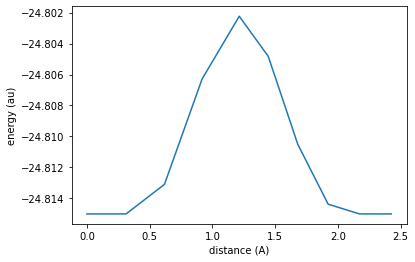

In [8]:
import pandas as pd

df = pd.read_table('outputfiles/neb/ch3cl-neb-1.ener', header=None, index_col=0, sep=' '*8)

last_step = df.iloc[-1, :]

energies = last_step[:10]
dists = np.concatenate(([0], np.cumsum(last_step[10:])))
plt.plot(dists, energies)
plt.xlabel('distance (A)')
plt.ylabel('energy (au)')

act_e = max(energies) - min(energies)
print(f'the activation energy is {act_e} au')

As expected, the energy rises and reaches a maxmimum in the middle, which is where the transition state happens, and then goes back down to the same exact energy because the final configuration is the same.

The activation energy is calculated to be 0.013 au which is around 7 kcal/mol which seems to be in the correct order of magnitude.

In [ ]:
# Points: 5/5

#### End Assignment 2

### 1.3. Visualizing the trajectories

Out of curiosity (and, perhaps just as importantly, because we want to practice our `bash` scripting skills), we want to visualize the initial and equilibrium trajectories of the current nucleophilic substitution reaction. In the current `neb` directory, execute the following script in your shell:

```bash
$ files=`ls -1 *Replica*.xyz`
$ for f in $files
$ do
$ head -8 $f >> traj_init.xyz
$ done
```

This script will create a file `traj_init.xyz`, wherein the coordinates of the initial geometries of each of the 10 replicas are contained. The script to generate the trajectory of the *equilibrium* geometries is similar: the fourth line in the above script gets changed to

```bash
$ tail -8 $f >> traj_equi.xyz
```

All of the other lines remain the same.

#### Assignment 3: Initial and final trajectories

Using these scripts, generate the initial and equilibrium trajectory files. View them
in the Python notebook. What differences (if any) do you notice? Is this a trivial
exercise?

In [9]:
%%bash

cd outputfiles/neb

rm traj_init.xyz
rm traj_equi.xyz

files=$(ls -1 *Replica*.xyz)
for f in $files
do
    head -8 $f >> traj_init.xyz
    tail -8 $f >> traj_equi.xyz
done


In [10]:
init_traj = read('outputfiles/neb/traj_init.xyz', ':')
view_trajectory(init_traj)

NGLWidget(max_frame=9)

In [11]:
equi_traj = read('outputfiles/neb/traj_equi.xyz', ':')
view_trajectory(equi_traj)

NGLWidget(max_frame=9)

The exercise is not necessarily trivial since the optimized transition route might not be the same as a simle line between the initial and final positions. Here this is the case; in the final trajectory, as the carbon atom gets closer to the nucleophine, the substrate moves furthur away instead of staying in the same position.

In [ ]:
# Points: 5/5

#### End Assignment 3

#### Assignment 4: Energy vs. distance

Generate energy vs. distance plots of the initial and final configurations (similar to
Assignment 2) and comment on the results. *Hint*: please make your energy values
in eV and not Ha. Also, we need the values for the distance between neighbours
to be cumulative and not incremental, as they are currently in the output; to this
end, you might want to use the `np.cumsum()` method for the distances array

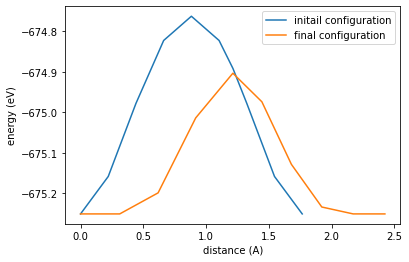

In [14]:
last_step = df.iloc[-1, :]
first_step = df.iloc[0, :]

first_energies = first_step[:10] * 27.2114
first_dists = np.concatenate(([0], np.cumsum(first_step[10:])))

last_energies = last_step[:10] * 27.2114
last_dists = np.concatenate(([0], np.cumsum(last_step[10:])))

plt.plot(first_dists, first_energies, label='initail configuration')
plt.plot(last_dists, last_energies, label='final configuration')
plt.xlabel('distance (A)')
plt.ylabel('energy (eV)')
plt.legend()

The final trajectory goes through a lower energy transition state. It also spans along a longer distance which is also seen in the visualizations in the last part.

In [ ]:
# Points: 5/5

#### End Assignment 4

## 2. Free energy surface

The **Helmholtz free energy** $F$ is defined within the canonical ensemble as

\begin{equation}
    F(s) = -k_BT \log(P(s))
\end{equation}

where $k_B$ is the Boltzmann constant, $T$ is temperature in kelvin, $\log$ is the natural logarithm, $s$ is the set of collective variables CVs (explained later), and $P(s)$ is the probability that the system have the set of CV values $s$.

Sampling the free energy surface (FES) of a chemical system is a convenient method to explore various stable conformations and possible reaction pathways. To calculate the FES for complicated systems, advanced sampling methods (umbrella sampling, metadynamics, parallel tempering, ...) must be used. Nonetheless, for our simple $S_N2$ reaction, we will use unbiased molecular dynamics (MD).

The FES is a projection of the high-dimensional free energy vector space onto a lesser- (usually two-) dimensional landscape. These two dimensions are called collective variables (CV), and they must be chosen in such a way that various stable conformations can be distinguished, and the reaction pathways can be adequately described by the FES. For complex systems, the choice of CVs is a non-trivial task; fortunately, however, for our simple system, the choice is simple: we take the distances of the two Cl anions from the central C as the CV.

To help the calculation sample the relevant parts of the FES, we will include restraints in the MD run, which prevent the Cl anions from drifting too far from the molecule. Open the `md.inp` input file, which runs the MD calculation and prints out the CV values for every step.

Submit the calculation (possibly reducing the number of steps in the interest of time). Once it is finished, execute the following cells and modify the variable `colvar\_path` variable appropriately. Execute the following Python code to calculate the FES from the `ch3f-COLVAR.metadynLog` output file produced by the MD calculation run. The structure of the `.metadynLog` file is: 

* 0th column: duration of an integration timestep (in fs);
* 1"th" column: value of the first CV, ie, distance between C and the first Cl atom;
* 2"th" column: value of the second CV, ie, distance between C and the second Cl atom. 

In [26]:
bohr_2_angstrom = 0.529177
kb = 8.6173303e-5 # eV * K^-1

temperature = 800.0    #Change temperature!
colvar_path = "outputfiles/md/20000steps_800K/ch3f-COLVAR.metadynLog"

In [27]:
# Load the colvar file
colvar_raw = np.loadtxt(colvar_path)

/var/folders/ll/zmr117x55qlg3n_0vbpf26rr0000gn/T/ipykernel_16866/2677578902.py:12: RuntimeWarning: divide by zero encountered in log
  fes = -kb * temperature * np.log(prob)


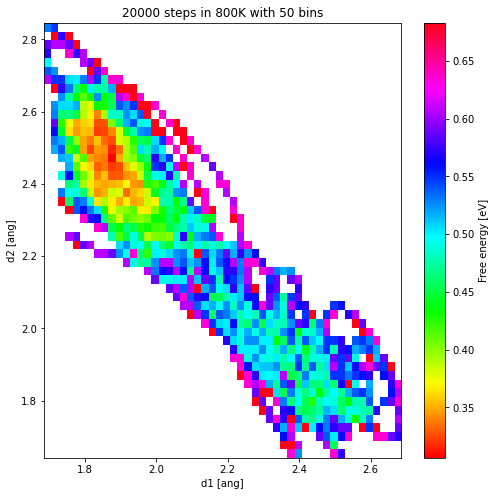

In [28]:
def plot_heatmap(colvar, bins, temperature, title=None): # converted the code to a function to make it reuseable
    # Extract the two CVs
    d1 = colvar[:, 1] * bohr_2_angstrom
    d2 = colvar[:, 2] * bohr_2_angstrom
    # Create a 2d histogram corresponding to the CV occurances
    cv_hist = np.histogram2d(d1, d2, bins=bins)

    # probability from the histogram
    prob = cv_hist[0]/len(d1)

    # Free energy surface
    fes = -kb * temperature * np.log(prob)

    # Save the image
    extent = (np.min(cv_hist[1]), np.max(cv_hist[1]), 
            np.min(cv_hist[2]), np.max(cv_hist[2]))
    plt.figure(figsize=(8, 8))
    plt.imshow(fes.T, extent=extent, aspect='auto',
            origin='lower', cmap='hsv')
    cbar = plt.colorbar()
    cbar.set_label("Free energy [eV]")
    plt.xlabel("d1 [ang]")
    plt.ylabel("d2 [ang]")
    plt.title(title)
    #plt.show()
    #plt.savefig("./fes.png", dpi=200)
    #plt.close()

plot_heatmap(colvar_raw, 50, temperature, '20000 steps in 800K with 50 bins')

#### Assignment 5: Temperature dependence of the FES
Submit the calculation (it will take a few hours) using 
`$ sbatch run.sh`
and, once it is finished, generate the FES plot and compare it with that using only
20000 steps in Figure 3. Discuss the differences.
Then run the calculations of  for different temperatures: 400K, 800K, 1200K, 1600K,
and in so doing making sure to change `TEMPERATURE` in both the respective input
file and in the above Python script.
In general, how does potential energy differ from free energy? For the present
reaction, what are the activation barriers from the different free energy surfaces?
How and why do they differ from the NEB barrier?

/var/folders/ll/zmr117x55qlg3n_0vbpf26rr0000gn/T/ipykernel_16866/2677578902.py:12: RuntimeWarning: divide by zero encountered in log
  fes = -kb * temperature * np.log(prob)


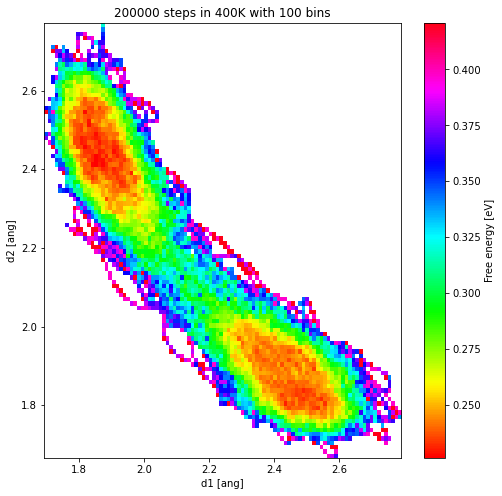

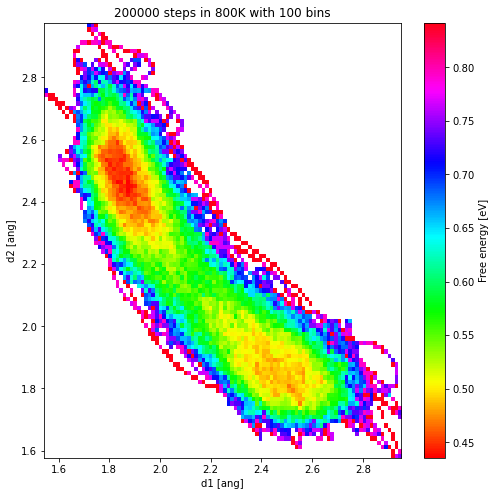

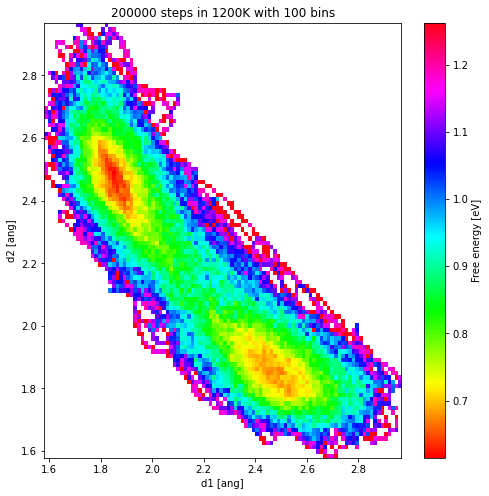

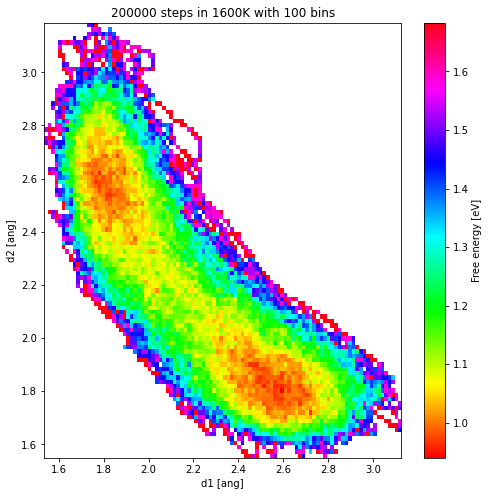

In [29]:
for temp in [400, 800, 1200, 1600]:
    colvar_raw = np.loadtxt(f"outputfiles/md/200000steps_{temp}K/ch3f-COLVAR.metadynLog")
    plot_heatmap(colvar_raw, 100, temp, f'200000 steps in {temp}K with 100 bins')

Free energy has an element of entropy inside it in addition to the potential energy. This means that if a state has higher degeneracy, its free energy will be lower. 

The activation barriers here is the route from the two basins in the PES. The main difference with NEB is that there is no hypothetical "strings" that connects the points in the trajectory together, and the movemnt is solely governed by newton's EOM.

We can also see that as the temperature increases, the basins get wider, the barrier gets lower in energy and in general, a more wider area of the configuration space is explored.

In [ ]:
# Points: 20/20

#### End Assignment 5

In [ ]:
"""
TOTAL POINTS: 40/40
"""